In [1]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

In [2]:
import os

import tensorflow as tf
from tensorflow import keras

print(tf.version.VERSION)

2.8.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')
drive.mount("/content/drive",force_remount= True)

Mounted at /content/drive
Mounted at /content/drive


In [4]:
class Config:
  DATASET_PATH ="/content/drive/MyDrive/Dataset/CrossRoad1/Train_frame"
  SINGLE_TEST_PATH = "/content/drive/MyDrive/Dataset/CrossRoad1/Test_frame/Test007"
  BATCH_SIZE = 4
  EPOCHS = 3
  MODEL_PATH = "/content/drive/MyDrive/model.h5"
  MODEL_2_PATH = "/content/drive/MyDrive/model2.h5"

In [5]:
from os import listdir
from os.path import isfile, join, isdir
import numpy as np
from PIL import Image
from skimage.transform import resize
def get_clips_by_stride(stride, frames_list, sequence_size):
    """ For data augmenting purposes.
    Parameters
    ----------
    stride : int
        The distance between two consecutive frames
    frames_list : list
        A list of sorted frames of shape 256 X 256
    sequence_size: int
        The size of the lstm sequence
    Returns
    -------
    list
        A list of clips , 10 frames each
    """
    clips = []
    sz = len(frames_list)
    clip = np.zeros(shape=(sequence_size, 256, 256, 1))
    cnt = 0
    for start in range(0, stride):
        for i in range(start, sz, stride):
            clip[cnt, :, :, 0] = frames_list[i]
            cnt = cnt + 1
            if cnt == sequence_size:
                clips.append(np.copy(clip))
                cnt = 0
    return clips

def get_training_set():
    """
    Returns
    -------
    list
        A list of training sequences of shape (NUMBER_OF_SEQUENCES,SINGLE_SEQUENCE_SIZE,FRAME_WIDTH,FRAME_HEIGHT,1)
    """
    #####################################
    # cache = shelve.open(Config.CACHE_PATH)
    # return cache["datasetLSTM"]
    #####################################
    clips = []
    # loop over the training folders (Train000,Train001,..)
    for f in sorted(listdir(Config.DATASET_PATH)):
        if(f == "Train009") :
          break
        directory_path = join(Config.DATASET_PATH, f)
        if isdir(directory_path):
            print(f)
            all_frames = []
            # loop over all the images in the folder (0.tif,1.tif,..,199.tif)
            for c in sorted(listdir(directory_path)):
                img_path = join(directory_path, c)
                if str(img_path)[-3:] == "jpg":
                    img = Image.open(img_path)
                    img = np.array(img, dtype=np.float32)
                    img = resize(img, (256, 256, 3))
                    img = np.array(img, dtype=np.float32) / 256.0
                    #convert the image into grayscale
                    img = 0.2989*img[:,:,0] + 0.5870*img[:,:,1] + 0.1140*img[:,:,2]
                    all_frames.append(img)
            # get the 10-frames sequences from the list of images after applying data augmentation
            for stride in range(1, 3):
                clips.extend(get_clips_by_stride(stride=stride, frames_list=all_frames, sequence_size=10))
    return clips

In [6]:
########################### First MODEL #############################################

import tensorflow as tf
import keras
from tensorflow.keras.layers import Conv2DTranspose, ConvLSTM2D,Bidirectional, BatchNormalization, TimeDistributed, Conv2D
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LayerNormalization

def get_model(reload_model=True):
    """
    Parameters
    ----------
    reload_model : bool
        Load saved model or retrain it
    """

    if not reload_model:
        return load_model(Config.MODEL_PATH,custom_objects={'LayerNormalization': LayerNormalization})
    training_set = get_training_set()
    training_set = np.array(training_set)
    seq = Sequential()
    seq.add(TimeDistributed(Conv2D(128, (11, 11), strides=4, padding="same"), batch_input_shape=(None, 10, 256, 256, 1)))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2D(64, (5, 5), strides=2, padding="same")))
    seq.add(LayerNormalization())
    # # # # #
    seq.add(ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    seq.add(ConvLSTM2D(32, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    seq.add(ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    # # # # #
    seq.add(TimeDistributed(Conv2DTranspose(64, (5, 5), strides=2, padding="same")))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2DTranspose(128, (11, 11), strides=4, padding="same")))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2D(1, (11, 11), activation="sigmoid", padding="same")))
    print(seq.summary())
    seq.compile(loss='mse', optimizer = tf.keras.optimizers.Adam(lr=1e-4, decay=1e-5, epsilon=1e-6))
    seq.fit(training_set, training_set,
            batch_size=Config.BATCH_SIZE, epochs=Config.EPOCHS, shuffle=False)
    seq.save(Config.MODEL_PATH)
    return seq

In [6]:
##################################### Attention layer Code ##################################################

from keras.layers import *
from keras.models import *
from keras import backend as K

class attention(Layer):
    
    def __init__(self, return_sequences=True):
        self.return_sequences = return_sequences
        super(attention,self).__init__()
        
    def build(self, input_shape):
        print(input_shape)
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),initializer="normal")

        self.b=self.add_weight(name="att_bias", shape = (1,),initializer="zeros")
        
        super(attention,self).build(input_shape)
        
    def call(self, x):
        
        e = K.tanh(K.dot(x,self.W)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a
        
        if self.return_sequences:
            return output
        
        return K.sum(output, axis=1)
        
    def get_config(self):
        return super(attention,self).get_config()

    

In [7]:
########################### Prepare Second MODEL #############################################


import tensorflow as tf
import keras
from keras.layers import *
from keras.models import *
from tensorflow.keras.layers import Conv2DTranspose, ConvLSTM2D,Bidirectional, BatchNormalization, TimeDistributed, Conv2D
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LayerNormalization
#from tensorflow.keras.layers import MultiHeadAttention


def prep_model() :
    model2 = Sequential()

    #model2.add(Embedding(n_unique_words, 128, input_length=maxlen))
    #model2.add(Bidirectional(LSTM(64, return_sequences=True)))
    #model2.add(Dropout(0.5))
    #model2.add(Dense(1, activation='sigmoid'))
    #model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 

    model2.add(TimeDistributed(Conv2D(128, (11, 11), strides=4, padding="same"), batch_input_shape=(None, 10, 256, 256, 1)))
    model2.add(LayerNormalization())
    model2.add(TimeDistributed(Conv2D(64, (5, 5), strides=2, padding="same")))
    model2.add(LayerNormalization())
    # # # # #
    model2.add(Bidirectional(ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True)))
    #print(model2.summary())
    #model2.add(MultiHeadAttention(num_heads=2, key_dim=2, attention_axes=(2, 3)))
    model2.add(tf.keras.layers.Reshape((10,1024,128)))
    #print(model2.summary())
    model2.add(attention())#)) # receive 3D and output 3D
    model2.add(tf.keras.layers.Reshape((10, 32,32,128)))
    model2.add(LayerNormalization())
    model2.add(Bidirectional(ConvLSTM2D(32, (3, 3), padding="same", return_sequences=True)))
    #model2.add(attention(return_sequences=True)) # receive 3D and output 3D
    model2.add(LayerNormalization())
    model2.add(Bidirectional(ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True)))#model2.add(attention(return_sequences=True)) # receive 3D and output 3D
    model2.add(LayerNormalization())
    # # # # #
    model2.add(TimeDistributed(Conv2DTranspose(64, (5, 5), strides=2, padding="same")))
    model2.add(LayerNormalization())
    model2.add(TimeDistributed(Conv2DTranspose(128, (11, 11), strides=4, padding="same")))
    model2.add(LayerNormalization())
    model2.add(TimeDistributed(Conv2D(1, (11, 11), activation="sigmoid", padding="same")))

    print(model2.summary())

    return model2

prep_model()



(None, 10, 1024, 128)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 10, 64, 64, 128)  15616     
 ibuted)                                                         
                                                                 
 layer_normalization (LayerN  (None, 10, 64, 64, 128)  256       
 ormalization)                                                   
                                                                 
 time_distributed_1 (TimeDis  (None, 10, 32, 32, 64)   204864    
 tributed)                                                       
                                                                 
 layer_normalization_1 (Laye  (None, 10, 32, 32, 64)   128       
 rNormalization)                                                 
                                                                 
 bidirectional (Bidirectiona  (Non

In [8]:
########################### Get & Save Second MODEL #############################################
def get_model(reload_model=True):
    """
    Parameters
    ----------
    reload_model : bool
        Load saved model or retrain it
    """

    if not reload_model:
        return load_model(Config.MODEL_2_PATH,custom_objects={'LayerNormalization': LayerNormalization})

    training_set = get_training_set()
    training_set = np.array(training_set)

    model2 = prep_model()
   
    model2.compile(loss='mse', optimizer = tf.keras.optimizers.Adam(lr=1e-4, decay=1e-5, epsilon=1e-6))
    model2.fit(training_set, training_set,batch_size=Config.BATCH_SIZE, epochs=Config.EPOCHS, shuffle=False)
    model2.save(Config.MODEL_2_PATH)

    return model2


In [ ]:
#model2.summary()

In [9]:
def get_single_test():
    sz = 250
    test = np.zeros(shape=(sz, 256, 256, 1))
    cnt = 0
    for f in sorted(listdir(Config.SINGLE_TEST_PATH)):
        if str(join(Config.SINGLE_TEST_PATH, f))[-3:] == "jpg":
            img = Image.open(join(Config.SINGLE_TEST_PATH, f))
            img = np.array(img, dtype=np.float32)
            img = resize(img, (256, 256, 3))
            img = np.array(img, dtype=np.float32) / 256.0
            #convert the image into grayscale
            img = 0.2989*img[:,:,0] + 0.5870*img[:,:,1] + 0.1140*img[:,:,2]
            #resize((256, 256,3))
            #img = np.array(img, dtype=np.float32) / 256.0
            test[cnt, :, :, 0] = img
            cnt = cnt + 1
    return test

In [ ]:
model = get_model(True)
print("got model")

Train001
Train002
Train003
Train004
Train005
Train006
Train007
Train008
(None, 10, 1024, 128)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_5 (TimeDis  (None, 10, 64, 64, 128)  15616     
 tributed)                                                       
                                                                 
 layer_normalization_7 (Laye  (None, 10, 64, 64, 128)  256       
 rNormalization)                                                 
                                                                 
 time_distributed_6 (TimeDis  (None, 10, 32, 32, 64)   204864    
 tributed)                                                       
                                                                 
 layer_normalization_8 (Laye  (None, 10, 32, 32, 64)   128       
 rNormalization)                                                 
                          

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/3
 28/100 [=======>......................] - ETA: 3:47 - loss: 0.0608

In [11]:
import matplotlib.pyplot as plt
import sklearn.metrics as metrics


def evaluate():
    test = get_single_test()
    print("got test")
    sz = test.shape[0] - 10
    sequences = np.zeros((sz, 10, 256, 256, 1))
    # apply the sliding window technique to get the sequences
    for i in range(0, sz):
        clip = np.zeros((10, 256, 256, 1))
        for j in range(0, 10):
            clip[j] = test[i + j, :, :, :]
        sequences[i] = clip

    # get the reconstruction cost of all the sequences
    reconstructed_sequences = model.predict(sequences,batch_size=4)
    sequences_reconstruction_cost = np.array([np.linalg.norm(np.subtract(sequences[i],reconstructed_sequences[i])) for i in range(0,sz)])
    sa = (sequences_reconstruction_cost - np.min(sequences_reconstruction_cost)) / np.max(sequences_reconstruction_cost)
    sr = 1.0 - sa

    # plot the regularity scores
    plt.plot(sr)
    plt.ylabel('regularity score Sr(t)')
    plt.xlabel('frame t')
    plt.show()

got test


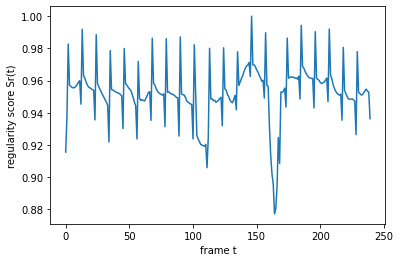

In [12]:
evaluate()

In [ ]:
import os

from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Lambda, Dot, Activation, Concatenate, Layer

# KERAS_ATTENTION_DEBUG: If set to 1. Will switch to debug mode.
# In debug mode, the class Attention is no longer a Keras layer.
# What it means in practice is that we can have access to the internal values
# of each tensor. If we don't use debug, Keras treats the object
# as a layer and we can only get the final output.
debug_flag = int(os.environ.get('KERAS_ATTENTION_DEBUG', 0))


class Attention(object if debug_flag else Layer):

    def __init__(self, units=128, **kwargs):
        super(Attention, self).__init__(**kwargs)
        self.units = units

    # noinspection PyAttributeOutsideInit
    def build(self, input_shape):
        print(input_shape)
        input_dim = int(input_shape[-1])
        with K.name_scope(self.name if not debug_flag else 'attention'):
            self.attention_score_vec = Dense(input_dim, use_bias=False, name='attention_score_vec')
            self.h_t = Lambda(lambda x: x[:, -1, :], output_shape=(input_dim,), name='last_hidden_state')
            self.attention_score = Dot(axes=[1, 2], name='attention_score')
            self.attention_weight = Activation('softmax', name='attention_weight')
            self.context_vector = Dot(axes=[1, 1], name='context_vector')
            self.attention_output = Concatenate(name='attention_output')
            self.attention_vector = Dense(self.units, use_bias=False, activation='tanh', name='attention_vector')
        if not debug_flag:
            # debug: the call to build() is done in call().
            super(Attention, self).build(input_shape)

    def compute_output_shape(self, input_shape):
        return input_shape[0], self.units

    def __call__(self, inputs, training=None, **kwargs):
        if debug_flag:
            return self.call(inputs, training, **kwargs)
        else:
            return super(Attention, self).__call__(inputs, training, **kwargs)

    # noinspection PyUnusedLocal
    def call(self, inputs, training=None, **kwargs):
        """
        Many-to-one attention mechanism for Keras.
        @param inputs: 3D tensor with shape (batch_size, time_steps, input_dim).
        @param training: not used in this layer.
        @return: 2D tensor with shape (batch_size, units)
        @author: felixhao28, philipperemy.
        """
        if debug_flag:
            self.build(inputs.shape)
        # Inside dense layer
        #              hidden_states            dot               W            =>           score_first_part
        # (batch_size, time_steps, hidden_size) dot (hidden_size, hidden_size) => (batch_size, time_steps, hidden_size)
        # W is the trainable weight matrix of attention Luong's multiplicative style score
        score_first_part = self.attention_score_vec(inputs)
        #            score_first_part           dot        last_hidden_state     => attention_weights
        # (batch_size, time_steps, hidden_size) dot   (batch_size, hidden_size)  => (batch_size, time_steps)
        h_t = self.h_t(inputs)
        score = self.attention_score([h_t, score_first_part])
        attention_weights = self.attention_weight(score)
        # (batch_size, time_steps, hidden_size) dot (batch_size, time_steps) => (batch_size, hidden_size)
        context_vector = self.context_vector([inputs, attention_weights])
        pre_activation = self.attention_output([context_vector, h_t])
        attention_vector = self.attention_vector(pre_activation)
        return attention_vector

    def get_config(self):
        """
        Returns the config of a the layer. This is used for saving and loading from a model
        :return: python dictionary with specs to rebuild layer
        """
        config = super(Attention, self).get_config()
        config.update({'units': self.units})
        return config